In [5]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#use_tf_keras = True
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import itertools
from tqdm import tqdm
#import tensorlayer as tl
#from imgaug import augmenters as iaa
#import imgaug as ia
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore")

In [8]:
DATA_DIR = Path('C:/Users/I355730/Documents/Kaagle/iMaterialist_Fashion_2019_at_FGVC6/')
ROOT_DIR = Path('C:/Users/I355730/Documents/Kaagle/iMaterialist_Fashion_2019_at_FGVC6/')

NUM_CATS = 46 
IMAGE_SIZE = 512 

In [13]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git
!rm -rf images assets

Cloning into 'Mask_RCNN'...
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
sys.path.append(str(ROOT_DIR/'Mask_RCNN'))

# sys.path.remove(ROOT_DIR/'Mask_RCNN')
# print(sys.path)
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [9]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [20]:
segment_df = pd.read_csv(DATA_DIR/"pred_10k_df.csv")
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

KeyError: 'ClassId'

In [17]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  45625


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [11]:
def resize_image(image_path):
    print(image_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [15]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'train'/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('C:\\Users\\I355730\\Documents\\Kaagle\\iMaterialist_Fashion_2019_at_FGVC6\\train\\7768e7c98a99c4efe4b81326c0a5ef38.jpg', ['skirt', 'shoe', 'shoe', 'top, t-shirt, sweatshirt', 'neckline'])
C:\Users\I355730\Documents\Kaagle\iMaterialist_Fashion_2019_at_FGVC6\train\7768e7c98a99c4efe4b81326c0a5ef38.jpg


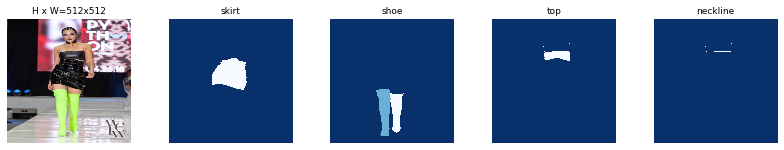

('C:\\Users\\I355730\\Documents\\Kaagle\\iMaterialist_Fashion_2019_at_FGVC6\\train\\ceba32a733439bbda99bb489b3e791e8.jpg', ['sleeve', 'sleeve', 'neckline', 'belt', 'dress'])
C:\Users\I355730\Documents\Kaagle\iMaterialist_Fashion_2019_at_FGVC6\train\ceba32a733439bbda99bb489b3e791e8.jpg


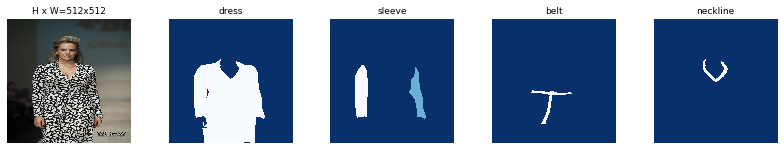

('C:\\Users\\I355730\\Documents\\Kaagle\\iMaterialist_Fashion_2019_at_FGVC6\\train\\e326d60d15f533de0578a56448a82d92.jpg', ['shoe', 'shoe', 'shorts', 'pocket', 'pocket', 'rivet', 'rivet', 'top, t-shirt, sweatshirt', 'neckline'])
C:\Users\I355730\Documents\Kaagle\iMaterialist_Fashion_2019_at_FGVC6\train\e326d60d15f533de0578a56448a82d92.jpg


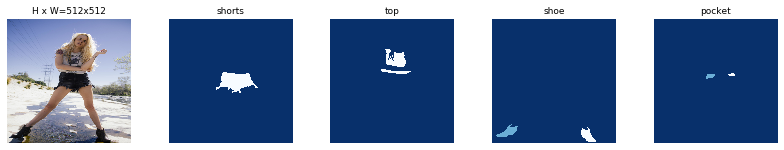

('C:\\Users\\I355730\\Documents\\Kaagle\\iMaterialist_Fashion_2019_at_FGVC6\\train\\73c3fde52492c9443a3c6875dd489a84.jpg', ['dress', 'neckline', 'belt', 'buckle', 'sleeve', 'sleeve', 'jacket', 'lapel', 'pocket', 'pocket', 'pocket'])
C:\Users\I355730\Documents\Kaagle\iMaterialist_Fashion_2019_at_FGVC6\train\73c3fde52492c9443a3c6875dd489a84.jpg


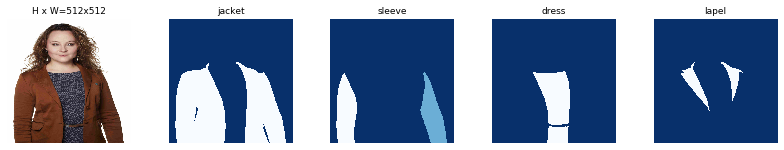

('C:\\Users\\I355730\\Documents\\Kaagle\\iMaterialist_Fashion_2019_at_FGVC6\\train\\fac8a6aebaa340f6ffdcc0d400de714a.jpg', ['pants', 'top, t-shirt, sweatshirt', 'neckline'])
C:\Users\I355730\Documents\Kaagle\iMaterialist_Fashion_2019_at_FGVC6\train\fac8a6aebaa340f6ffdcc0d400de714a.jpg


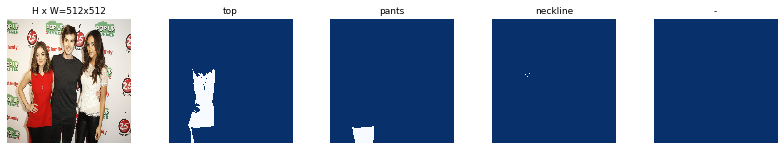

('C:\\Users\\I355730\\Documents\\Kaagle\\iMaterialist_Fashion_2019_at_FGVC6\\train\\7b0010e40c7db36ece2dc08fa5734a06.jpg', ['shoe', 'shoe', 'dress', 'headband, head covering, hair accessory', 'neckline'])
C:\Users\I355730\Documents\Kaagle\iMaterialist_Fashion_2019_at_FGVC6\train\7b0010e40c7db36ece2dc08fa5734a06.jpg


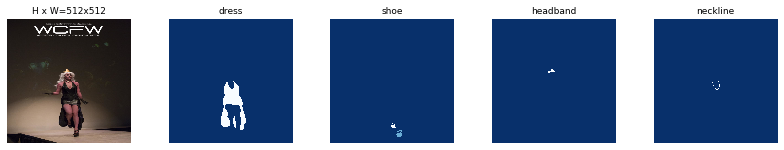

In [18]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)